# NTM - dataframe calculator
### Enrico Gavagnin

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import py_fort_myrmidon as fm
import datetime
import networkx as nx
import networkx.algorithms.community as nxc
#import community
import statistics
import scipy.stats as stats
import os
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
working_dir = '/media/eg15396/EG_DATA-7/NTM/'
myrm_list = sorted([ s for s in os.listdir(working_dir) if s[15:17] == '.m'])

## Property calculator (fixed time-window)

In [3]:
# function to compute netowrk properties
def G_prop(G, exp, start, end, time_win, max_gap, name, var, PLOT_HM_check = False):
    
    # compute connencted components
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    GC = G.subgraph(Gcc[0])
    res = 1
    
    # Best partition Louvian Method
    best_partition = nxc.louvain_communities(G, weight='weight', resolution=res)
    best_partition_CC = nxc.louvain_communities(GC, weight='weight', resolution=res)
    best_partition_CC_res_09 = nxc.louvain_communities(GC, weight='weight', resolution=0.9)
    if var != None:
        best_partition_CC_3p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=3, best_n=3, resolution=res)
        mode_p = mode_communities_dic[var['link_type']][name[11:14]][time_win]
    else:
        best_partition_CC_3p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=1, best_n=1, resolution=res)
        mode_p = 1
        
    best_partition_CC_mode_p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=mode_p, best_n=mode_p, resolution=res)
    
    
    # Heatmap partition plotting (optional)
    if PLOT_HM_check:
        
        # Save HM_partition Louvain
        directory = 'plots/HM_partition/unsup_mod/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC, 
                          directory + '/', 
                          name[7:15] + attributes)
        
        # Save HM_partition 3 partition
        directory = 'plots/HM_partition/sup_mod3p/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC_3p, 
                          directory + '/', 
                          name[7:15] + attributes)
        
        # Save HM_partition mode parition
        directory = 'plots/HM_partition/sup_modmp/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC_mode_p, 
                          directory + '/', 
                          name[7:15] + attributes)

    return {'rep': int(name[8:10]),
            'exp': name[11:15],
            'start': fm.Time.ToDateTime(start), 
            'time_win': time_win, 
            'max_gap': max_gap,
            'GC': GC.number_of_nodes(),
            'ants': G.number_of_nodes(),
            'cMOD_communities': [len(best_partition_CC[i]) for i in range(len(best_partition_CC))],
            'cmpMOD_communities': [len(best_partition_CC_mode_p[i]) for i in range(len(best_partition_CC_mode_p))],
            'c3pMOD_communities': [len(best_partition_CC_3p[i]) for i in range(len(best_partition_CC_3p))],
            'cMODres09_communities': [len(best_partition_CC_res_09[i]) for i in range(len(best_partition_CC_res_09))],
            'MOD': nxc.modularity(G, best_partition),
            'cMOD': nxc.modularity(GC, best_partition_CC),
            'c3pMOD': nxc.modularity(GC, best_partition_CC_3p),
            'cmpMOD': nxc.modularity(GC, best_partition_CC_mode_p),
            'DEN': nx.density(G), 
            'wDEN': nx.adjacency_matrix(G).sum() / (G.number_of_nodes() * (G.number_of_nodes() - 1) * time_win),  # weighted density = sum all weights /(|V|*(|V|-1)/2 * time_win)
            'DIA': nx.diameter(GC),
            'wDIA': nx.diameter(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'RAD': nx.radius(GC),
            'wRAD': nx.radius(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'DEH': np.std([G.degree(n) for n in G.nodes()]),
            'cDEH': np.std([GC.degree(n) for n in GC.nodes()]),
            'wDEH': np.std(nx.adjacency_matrix(G).sum(axis=0)), # strength heterogeneity
            'cwDEH': np.std(nx.adjacency_matrix(GC).sum(axis=0)), # strength heterogeneity
            'CLS': np.mean([c for c in nx.clustering(G, weight='weight').values()]) 
            }

# initialise data-frame with properties
prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),[],fm.Time.Now(),[],1,1,myrm_list[0],var=None).keys())

## Heatmap partition

In [4]:
# Heatmap stack calculator

def compute_HM_stack(exp, start, end):
    
    # Number of ants
    N_ants = len(exp.Ants)    
    
    bins_x = range(0,8000, 50)
    bins_y = range(0,6000, 50)
    
    # initialise adj-matrix
    HM_stack = [np.zeros((len(bins_y)-1,len(bins_x)-1))]*N_ants

    # Populate network
    for i in fm.Query.ComputeAntTrajectories(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9)):
        
        #print(i.Positions[:,1])
        HM_stack[i.Ant - 1] = HM_stack[i.Ant - 1] + np.histogram2d(i.Positions[:,2],i.Positions[:,1], bins=[bins_y, bins_x])[0]           

    return HM_stack

# Function which plot heatmaps of partition
def PLOT_HM_partition(HM_stack, partition, fld_path, file_name):
    
    n_partition = len(partition)
    ant_list = list(frozenset().union(*list(partition)))
    
    HM_part = {p: np.zeros(np.shape(HM_stack[0])) for p in range(n_partition)}
    
    # build background
    background = np.zeros((np.shape(HM_stack[0])[0], np.shape(HM_stack[0])[1], 3))
    
    for a in ant_list:
        for c in range(3):
            background[:, :, c] += HM_stack[a]
    for c in range(3):
        background[:, :, c][background[:, :, c]>0] = 1

    fig, axs = plt.subplots(int(np.ceil(n_partition / 3)), 3, figsize=(15, 10))
    c = list(sns.color_palette()) + list(sns.color_palette("Set2"))

    for part_idx in range(n_partition):
        
        if n_partition >= 4:
            axs[part_idx // 3, part_idx % 3].imshow(background, interpolation='gaussian')
        else:
            axs[part_idx].imshow(background, interpolation='gaussian')


        part_size = 0
        for ant in ant_list:
            if ant in partition[part_idx]:
                part_size += 1
                HM_part[part_idx] += HM_stack[ant] 
   
        
        RGB = np.zeros((np.shape(HM_stack[0])[0], np.shape(HM_stack[0])[1], 4))

        mono_scale = HM_part[part_idx]
        mono_scale = mono_scale / np.nanpercentile(HM_part[part_idx], 98)
        mono_scale[mono_scale>1] = 1

        for rgb_idx in range(3): 
            RGB[:, :, rgb_idx] = c[part_idx][rgb_idx] 
        RGB[:, :, 3] = mono_scale

        # Plotting heatmap
        if n_partition >= 4:
            axs[part_idx // 3, part_idx % 3].imshow(RGB, interpolation='hamming') 
            axs[part_idx // 3, part_idx % 3].set_title('Community ' + str(part_idx+1) + ' - size: ' + str(part_size))
        else:
            axs[part_idx].imshow(RGB, interpolation='hamming') 
            axs[part_idx].set_title('Community ' + str(part_idx+1) + ' - size: ' + str(part_size))

    # remove axis 
    for idx_ax in range(int(np.ceil(n_partition / 3)) * 3):                
        if n_partition >= 4:
            axs[idx_ax // 3, idx_ax % 3].axis('off')
        else:
            axs[idx_ax].axis('off')
        

    plt.suptitle(file_name, fontweight="bold")
    plt.tight_layout()
    plt.savefig(fld_path + file_name + '.png', facecolor='white', transparent=False)
    plt.close()

## Graph calculator

In [24]:
# Function to compute the cumulative interaction function
def compute_G(exp, start, end, min_cum_duration, frm_rate, link_type):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))

    # Populate network
    
    if (link_type == 'length_inter') | (link_type == '#inter'):
        for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                                reportFullTrajectories= False)[1]:

            # Focus on Nest zone (id=1)
            if True:#(1 in i.Trajectories[1].Zones):

                if link_type == 'length_inter':
                # OPT1
                # WEIGHTS: cumulative interaction time
                    adj_mat[i.IDs[0]-1, i.IDs[1]-1] += (fm.Time.ToDateTime(i.End) - fm.Time.ToDateTime(i.Start)).total_seconds()

                elif link_type == '#inter':
                # OPT2
                # WEIGHTS: number of interactions
                    adj_mat[i.IDs[0]-1, i.IDs[1]-1] += 1
                
                    
    elif link_type == '#coll':
        
        for coll_frm in fm.Query.CollideFrames(exp,start=start,end=end):
            for coll in coll_frm[1].Collisions:
                if True:#(coll.Zone == 1):
                    adj_mat[coll.IDs[0]-1, coll.IDs[1]-1] += 1 / frm_rate


    else:
        raise TypeError('"link_type" not valid')

    # interaction filtering (remove weak connections)
    adj_mat[adj_mat <  min_cum_duration] = 0

    # network build
    G = nx.Graph(adj_mat)

    # store inverse of weights
    nx.set_edge_attributes(G, 
                           {(i,j): 1/adj_mat[j,i] if adj_mat[j,i]>0 else 0 for i in range(len(adj_mat)) for j in range(i)},
                           'inv_weight')
    return G



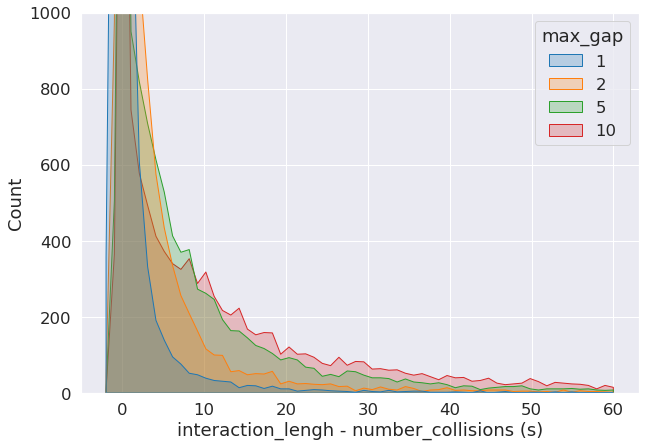

In [115]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6


error_record = pd.DataFrame()
# max gap for different interactions
for gap_idx, max_gap in enumerate([1, 2, 5, 10]):

    # minimum cumulative interaction duration (s)
    min_cum_duration = 0 

    myrm_file = myrm_list[20]

    # Open experiment file
    exp = fm.Experiment.Open(working_dir + myrm_file)

    ## ------ Time window ------ 
    # define time window of cumulative network
    start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                 timedelta(days = -1)).strftime("%Y-%m-%d")

    # ======== Total cumulative time window ========
    start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
    end = start.Add(fm.Duration(60 * 60 * 24 * 10**9))

    # ======== 1H window ========
    time_win_h = 3
    time_win = 60 * 60 * time_win_h


    tw = 1
    s = start.Add(fm.Duration(tw * time_win * 10**9))
    e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

    # Compute network
    G1 = compute_G(exp, s,   e, min_cum_duration, frm_rate, 'length_inter')
    G2 = compute_G(exp, s,   e, min_cum_duration, frm_rate, '#coll')
    diff_mat = np.triu((nx.adjacency_matrix(G1) - nx.adjacency_matrix(G2)).todense(), k=1)
    diff_array = diff_mat[np.nonzero(diff_mat)]
    error_record = pd.concat([error_record, 
                              pd.DataFrame({'interaction_lengh - number_collisions (s)': diff_array,
                                            'max_gap': [max_gap] * len(diff_array)})],
                             ignore_index=True)
plt.figure(figsize=(10,7))    
sns.set(font_scale = 1.5)
sns.histplot(error_record, x='interaction_lengh - number_collisions (s)', 
             hue='max_gap', element="poly", bins = np.linspace(-2.5,60.5,63),
             palette=sns.color_palette('tab10', 4))

plt.ylim([0,1000])
plt.savefig('inter_coll.png', facecolor='white', transparent=False)

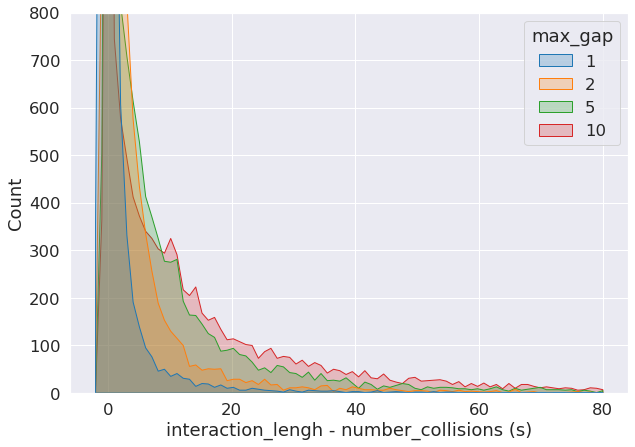

In [120]:
plt.figure(figsize=(10,7))    
sns.set(font_scale = 1.5)
sns.histplot(error_record, x='interaction_lengh - number_collisions (s)', 
             hue='max_gap', element="poly", bins = np.linspace(-2.5,80.5,83),
             palette=sns.color_palette('tab10', 4))

plt.ylim([0,800])
plt.savefig('inter_coll_2.png', facecolor='white', transparent=False)

In [110]:
diff_mat = np.triu((nx.adjacency_matrix(G1) - nx.adjacency_matrix(G2)).todense(), k=1)
diff_mat[np.nonzero(diff_mat)]

array([15.000114  , 11.33295033, -0.33331167, ..., 56.836192  ,
        0.66668767, -0.16708867])

In [100]:
np.shape(np.triu(nx.adjacency_matrix(G1).todense()))

(177, 177)

In [61]:
[
    nx.adjacency_matrix(G1).todense()[:,:].reshape(-1,).T[i] - nx.adjacency_matrix(G2).todense()[:,:].reshape(-1,).T[i] 
    for i in range(G1.number_of_nodes() ** 2)]

[matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[-0.16671167]]),
 matrix([[0.]]),
 matrix([[0.666693]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[-0.16670767]]),
 matrix([[-0.16713567]]),
 matrix([[-0.16666667]]),
 matrix([[-0.16664467]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[-0.16666667]]),
 matrix([[0.]]),
 matrix([[-0.16615333]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[-0.16669367]]),
 matrix([[0.]]),
 matrix([[5.499989]]),
 matrix([[0.]]),
 matrix([[0.]]),
 matrix([[2.000057]]),
 matrix([[0.]]),
 matrix([[-0.16666667]]),
 matrix([[0.]]),


In [55]:
[1]*3

[1, 1, 1]

In [29]:
mat1 = nx.adjacency_matrix(G1).todense()[:,:].reshape(-1,).T
mat1 = np.array(mat1)
#sns.histplot(mat, bins=range(int(np.max(mat))))
#plt.xlim(left=1)
np.shape(mat1)

(31329, 1)

In [28]:
error_record

[[[[[],
    array([[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]])],
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]])],
  array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]])],
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])]

In [30]:
mat2 = nx.adjacency_matrix(G2).todense()[:,:].reshape(-1,).T
mat2 = np.array(mat2)
#sns.histplot(mat, bins=range(int(np.max(mat))))
#plt.xlim(left=1)
np.shape(mat2)

(31329, 1)

(0.0, 200.0)

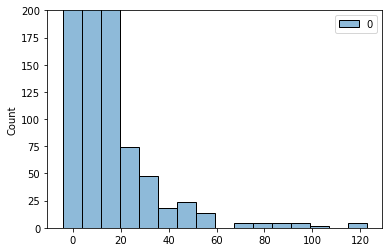

In [31]:
sns.histplot(mat1-mat2)
plt.ylim([0,200])

ValueError: attempt to get argmin of an empty sequence

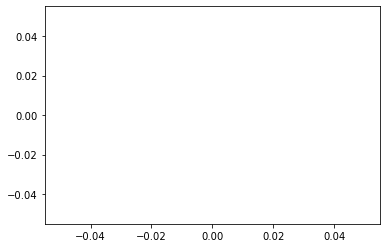

In [78]:
mat = nx.adjacency_matrix(G2).todense()[:,:].reshape(-1,).T - nx.adjacency_matrix(G1).todense()[:,:].reshape(-1,).T
sns.histplot(mat, bins=range(1,int(np.max(mat))))
plt.xlim(left=1)

## Computing mode of communitites louvain

## Loop myrm files

In [ ]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# max gap for different interactions
max_gap = 10

# minimum cumulative interaction duration (s)
min_cum_duration = 0 

# Read file with modes of communities number computed
with open('data/mode_communities_louvain.pkl', 'rb') as f:
    mode_communities_dic = pickle.load(f)

# maximum gap (s) for interaction computation
for link_type in ['length_inter']:#, '#inter']:
    
    # initialise data-frame with properties
    prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),[],fm.Time.Now(),[],1,1,myrm_list[0],var=None).keys())

    print(link_type)

    for myrm_file in myrm_list[20:]:
        
        if int(myrm_file[8:10])==41: 
            continue

        print(myrm_file)
        
        
    
        # Open experiment file
        exp = fm.Experiment.Open(working_dir + myrm_file)

        ## ------ Time window ------ 
        # define time window of cumulative network
        start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                     timedelta(days = -1)).strftime("%Y-%m-%d")

        # ======== Total cumulative time window ========
        start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
        end = start.Add(fm.Duration(60 * 60 * 24 * 10**9))

        # ======== 1H window ========
        for time_win_h in [1, 2, 3, 4, 6, 12]:
            time_win = 60 * 60 * time_win_h
            
            for tw in range(int(24/time_win_h)):
                print('Time_win:' + str (time_win_h) + 'h - time_slot: #' + str(tw + 1))
                s = start.Add(fm.Duration(tw * time_win * 10**9))
                e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

                # Compute network
                G = compute_G(exp, s, e, min_cum_duration, frm_rate, link_type)

                # variables dict
                var = {'link_type': link_type, 'time_win': time_win, 'h': tw}

                # Compute properties
                prop_df = prop_df.append(G_prop(G, exp, s, e, time_win, max_gap, myrm_file, var = var, PLOT_HM_check = False), ignore_index=True)
            
    # Save
    a_file = open('data/prop_data_12_6_4_3_2_1_' + link_type + '_nest.pkl', "wb")
    pickle.dump(prop_df, a_file)
    a_file.close()

prop_df

length_inter
EG_NTM_s13_DEHa.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot

TypeError: unsupported operand type(s) for |: 'str' and 'str'

In [ ]:
nx.dr